<a href="https://www.kaggle.com/code/samithsachidanandan/multimodal-brain-tumor-classification?scriptVersionId=292102326" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have proto

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from PIL import Image 

import warnings 
warnings.filterwarnings('ignore') 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.model_selection import train_test_split 
from datasets import load_dataset 
import fasttext 

import tensorflow as tf
from tensorflow.keras import layers, models



2026-01-15 20:24:53.001879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768508693.425801      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768508693.562768      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768508694.631450      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768508694.631488      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768508694.631490      55 computation_placer.cc:177] computation placer alr

# Loading the Data 

In [3]:
root_path = '/kaggle/input/brisc2025/brisc2025/classification_task/train'
image_paths = []
labels = []


In [4]:
for label in os.listdir(root_path):
    label_path = os.path.join(root_path, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            if img_file.lower().endswith(('.png','.jpg','.jpeg')):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)

In [5]:
df = pd.DataFrame({'image_path' : image_paths, 'label' : labels})
df

,image_path,label
0,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
1,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
2,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
3,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
4,/kaggle/input/brisc2025/brisc2025/classificati...,pituitary
...,...,...
4995,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4996,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4997,/kaggle/input/brisc2025/brisc2025/classificati...,glioma
4998,/kaggle/input/brisc2025/brisc2025/classificati...,glioma


# Basic Statistics

In [6]:
df.shape

(5000, 2)

In [7]:
df.columns 

Index(['image_path', 'label'], dtype='object')

In [8]:
df.duplicated().sum() 

np.int64(0)

In [9]:
df.isnull().sum() 

image_path    0
label         0
dtype: int64

In [10]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5000 non-null   object
 1   label       5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [11]:
df['label'].unique() 

array(['pituitary', 'no_tumor', 'meningioma', 'glioma'], dtype=object)

In [12]:
df['label'].value_counts() 

label
pituitary     1457
meningioma    1329
glioma        1147
no_tumor      1067
Name: count, dtype: int64

# EDA 

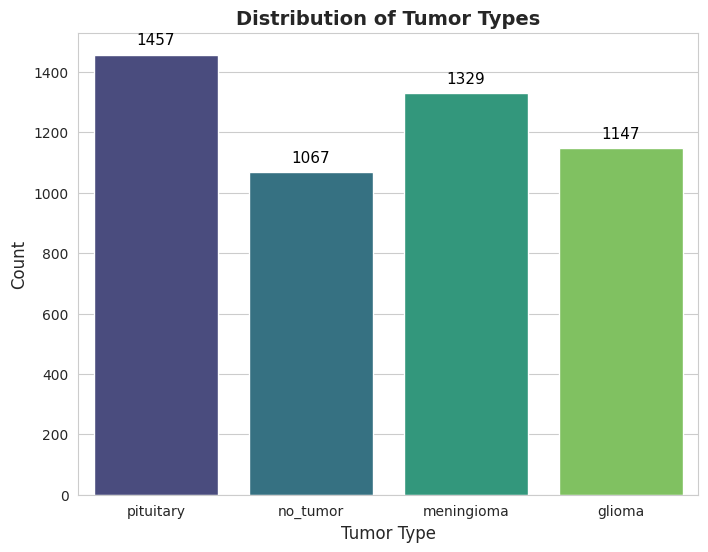

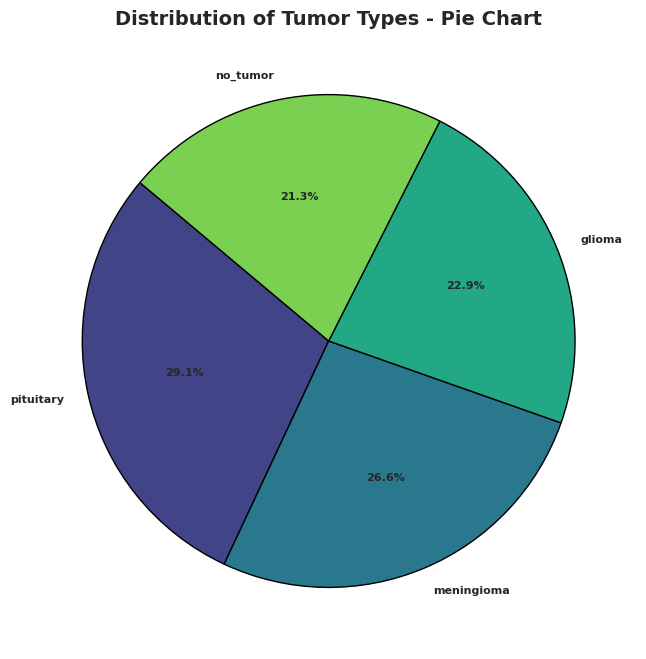

In [13]:
sns.set_style('whitegrid')
fx, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax) 
 
ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold') 
ax.set_xlabel("Tumor Type", fontsize=12) 
ax.set_ylabel("Count", fontsize=12) 
 
for p in ax.patches: 
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=11, color='black',  
                xytext=(0, 5), textcoords='offset points') 
 
plt.show() 
 
label_counts = df["label"].value_counts() 
 
fig, ax = plt.subplots(figsize=(10, 8)) 
colors = sns.color_palette("viridis", len(label_counts)) 
 
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',  
       startangle=140, colors=colors, textprops={'fontsize': 8, 'weight': 
'bold'}, 
       wedgeprops={'edgecolor': 'black', 'linewidth': 1}) 
 
ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, 
fontweight='bold') 
 
plt.show()


# Sample Images

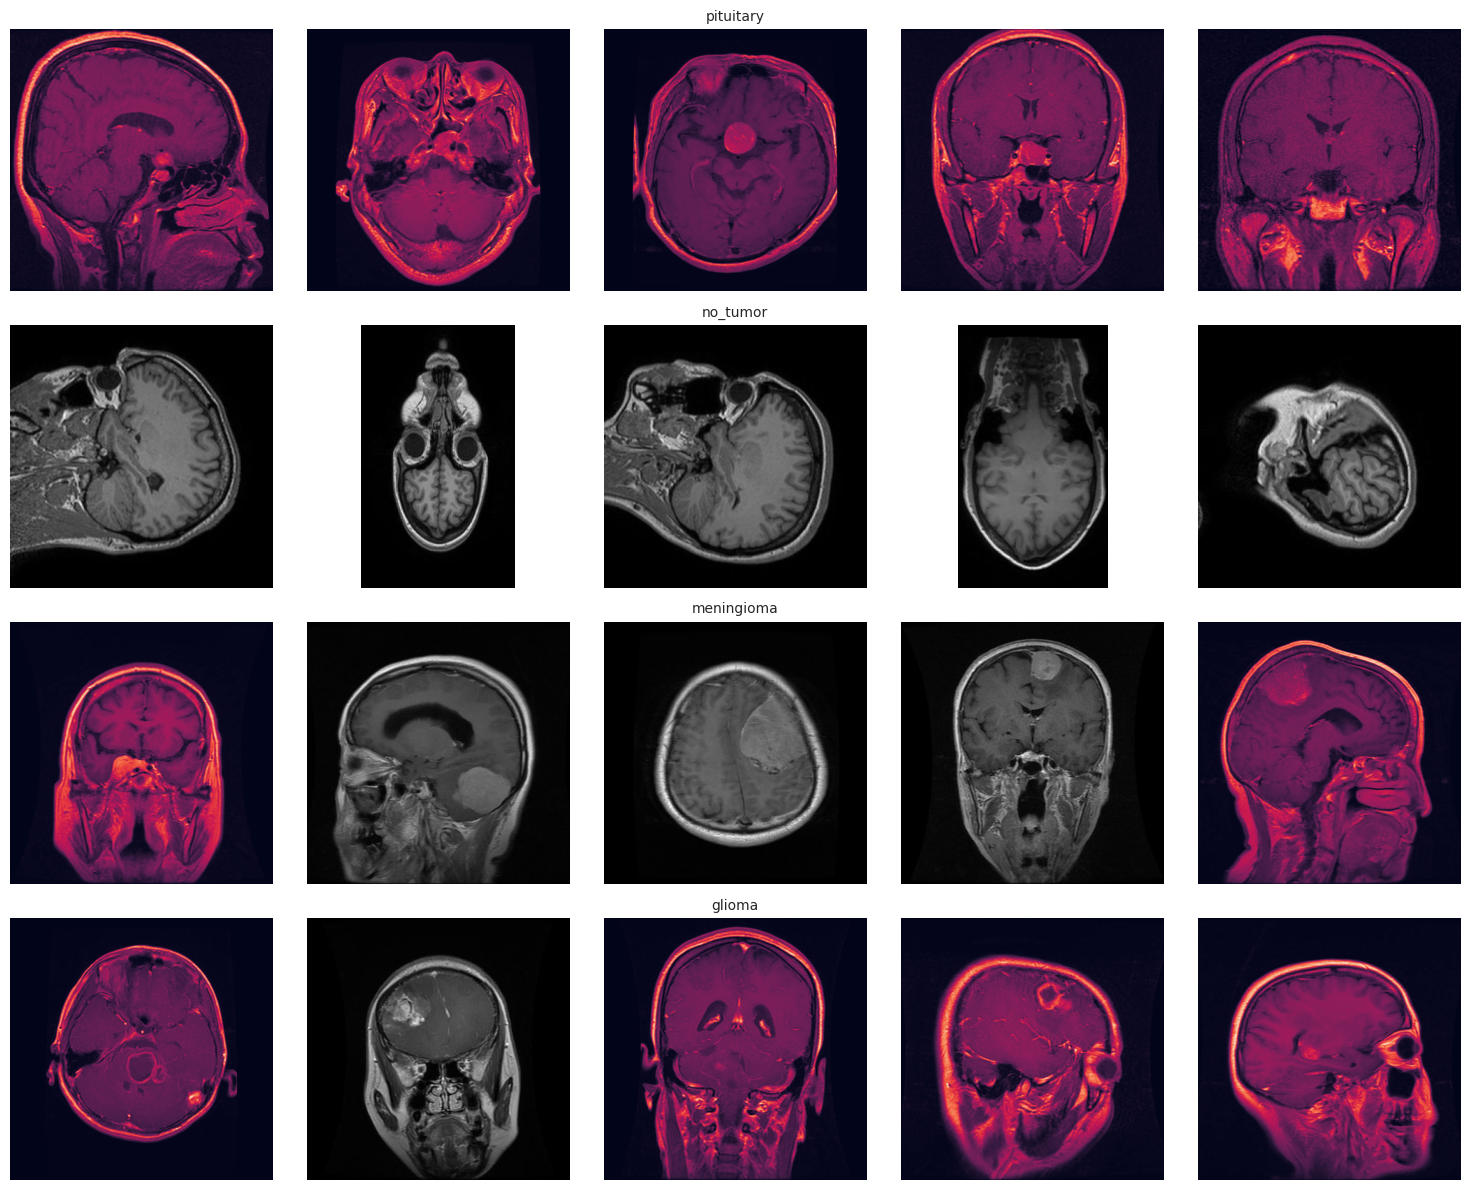

In [14]:

num_images = 5 

unique_labels = df['label'].unique() 

plt.figure(figsize=(15, len(unique_labels) * 3)) 
for row_idx, label in enumerate(unique_labels): 
    label_images = df[df['label'] ==label].head(num_images)['image_path'].tolist() 
    for col_idx, img_path in enumerate(label_images): 
        plt_idx = row_idx * num_images + col_idx + 1
        plt.subplot(len(unique_labels), num_images, plt_idx) 
        img = Image.open(img_path) 
        plt.imshow(img) 
        plt.axis('off') 
        if col_idx == 2:   
            plt.title(label, fontsize=10) 
plt.tight_layout() 
plt.show() 

# Train- Test Split

In [15]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42) 

max_samples = train_df['label'].value_counts().max() 

balanced_train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=max_samples, replace=True, random_state=42)).reset_index(drop=True) 

balanced_train_df = balanced_train_df[['image_path', 'label']] 

In [16]:
dataset = load_dataset("yzk/Sanskrit-SLP1", split="train") 
sanskrit_df = dataset.to_pandas() 
sanskrit_df['sentence'].str.strip().to_csv("sanskrit_corpus.txt", index=False, header=False) 


README.md:   0%|          | 0.00/494 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/54.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1313490 [00:00<?, ? examples/s]

# Training FastText word-embedding model

In [17]:
ft_model = fasttext.train_unsupervised( "sanskrit_corpus.txt", model="skipgram", dim=300, minn=3, epoch=5, thread=4 ) 
ft_model.save_model("sanskrit.bin") 


Read 8M words
Number of words:  120956
Number of labels: 0
Progress: 100.0% words/sec/thread:   20876 lr:  0.000000 avg.loss:  1.494247 ETA:   0h 0m 0s ETA:   0h 9m43s 0.049509 avg.loss:  3.100046 ETA:   0h 9m47s% words/sec/thread:   20036 lr:  0.048934 avg.loss:  2.513533 ETA:   0h 9m 0s% words/sec/thread:   20632 lr:  0.048752 avg.loss:  2.468341 ETA:   0h 8m42s 2.364346 ETA:   0h 8m16s  3.8% words/sec/thread:   21344 lr:  0.048122 avg.loss:  2.329531 ETA:   0h 8m18s  4.2% words/sec/thread:   21233 lr:  0.047880 avg.loss:  2.265764 ETA:   0h 8m18s words/sec/thread:   20790 lr:  0.047146 avg.loss:  2.120203 ETA:   0h 8m21s% words/sec/thread:   20824 lr:  0.047008 avg.loss:  2.119551 ETA:   0h 8m19s  20870 lr:  0.046963 avg.loss:  2.120878 ETA:   0h 8m17s 0.046802 avg.loss:  2.114413 ETA:   0h 8m13s 8m16s lr:  0.046219 avg.loss:  2.072455 ETA:   0h 8m20s 2.055818 ETA:   0h 8m17s words/sec/thread:   20606 lr:  0.045621 avg.loss:  2.045360 ETA:   0h 8m 9s words/sec/thread:   20653 lr:  0

In [18]:
particular_label = "no_tumor"


proto_emb = tf.convert_to_tensor(ft_model[particular_label],dtype=tf.float32)

proto_emb = tf.expand_dims(proto_emb, axis=0)


with tf.device('/GPU:0'):
    proto_emb = tf.identity(proto_emb)


label_to_idx = {
    'glioma': 0,
    'meningioma': 1,
    'no_tumor': 2,
    'pituitary': 3
}




categories = list(label_to_idx.keys())


I0000 00:00:1768509257.185964      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768509257.189969      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Loading and Normalization of Dataset 


In [19]:
IMG_SIZE = (224, 224)

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    mean = tf.constant([0.485, 0.456, 0.406])
    std = tf.constant([0.229, 0.224, 0.225])
    img = (img - mean) / std
    return img

In [20]:
def make_dataset(df, ft_model, label_to_idx, batch_size=32, shuffle=True):

    image_paths = df['image_path'].values
    labels = df['label'].values

    text_embeddings = np.stack([
        ft_model.get_word_vector(lbl) for lbl in labels
    ])

    label_indices = np.array([label_to_idx[lbl] for lbl in labels])

    ds = tf.data.Dataset.from_tensor_slices(
        (image_paths, text_embeddings, label_indices)
    )

    def _map_fn(path, text_emb, label):
        img = load_image(path)
        text_emb = tf.cast(text_emb, tf.float32)
        return (img, text_emb), label

    ds = ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Model 

In [21]:

image_input = layers.Input(shape=(224, 224, 3), name="image_input")
text_input  = layers.Input(shape=(300,), name="text_input")


x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(image_input)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(128, 3, strides=2, activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.GlobalAveragePooling2D()(x)
img_feat = layers.Dense(256, activation='relu')(x)


text_feat = layers.Dense(256, activation='relu')(text_input)


fused = layers.Concatenate()([img_feat, text_feat])
fused = layers.Dense(128, activation='relu')(fused)

proto_emb = tf.Variable(
    tf.random.normal((1, 300)),
    trainable=True,
    name="proto_embedding"
)

proto = layers.Dense(128, activation='relu')(proto_emb)

proto = layers.Lambda(
    lambda x: tf.repeat(x[0], tf.shape(x[1])[0], axis=0),
    name="proto_repeat"
)([proto, fused])

proto_dist = layers.Lambda(
    lambda x: tf.norm(x[0] - x[1], axis=1, keepdims=True),
    name="proto_distance"
)([fused, proto])


final_feat = layers.Concatenate()([fused, proto_dist])
output = layers.Dense(4, activation='softmax')(final_feat)


model = models.Model(
    inputs=[image_input, text_input],
    outputs=output
)


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 27, 27,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 13, 13,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     33,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     77,056 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proto_repeat        │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proto_distance      │ (None, 1)         │          0 │ dense_2[0][0],    │
│ (Lambda)            │                   │            │ proto_repeat[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 129)       │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ proto_distance[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │        520 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 259,592 (1014.03 KB)

 Trainable params: 259,592 (1014.03 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
train_ds = make_dataset(
    balanced_train_df,
    ft_model,
    label_to_idx,
    batch_size=32,
    shuffle=True
)

val_ds = make_dataset(
    val_df,
    ft_model,
    label_to_idx,
    batch_size=32,
    shuffle=False
)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Training 

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


I0000 00:00:1768509267.072709     152 service.cc:152] XLA service 0x7bc6a0007c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768509267.072756     152 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768509267.072762     152 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768509267.819397     152 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/146 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.1111 - loss: 1.6023      

I0000 00:00:1768509272.447431     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.8682 - loss: 0.5430 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.9805e-04
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 2.3982e-04 - val_accuracy: 1.0000 - val_loss: 8.6339e-05
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 1.0981e-04 - val_accuracy: 1.0000 - val_loss: 4.9276e-05
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 6.5177e-05 - val_accuracy: 1.0000 - val_loss: 3.1453e-05
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 1.0000 - loss: 4.2178e-05 - val_accuracy: 1.0000 - val_loss: 2.1501e-05
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 1.0000 - loss: 2.8977e-05 - val_accuracy: 1.0000 - val_loss: 1.5775e-05
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accura

In [26]:
model.save("brain_tumor_proto_classifier.keras")

# Visualization of results


In [27]:
def evaluate_model(model, dataset, categories):

    y_true, y_pred = [], []

    for (imgs, texts), labels in dataset:
        logits = model((imgs, texts), training=False)
        preds = tf.argmax(logits, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=categories,
        yticklabels=categories
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


    print(classification_report(y_true, y_pred, target_names=categories))
    

    return y_true, y_pred, cm


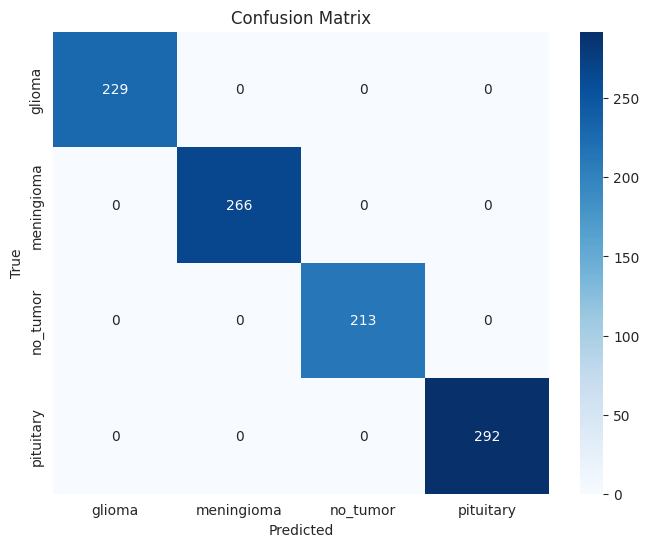

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       229
  meningioma       1.00      1.00      1.00       266
    no_tumor       1.00      1.00      1.00       213
   pituitary       1.00      1.00      1.00       292

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [28]:
y_true, y_pred, cm = evaluate_model(model, val_ds, categories)

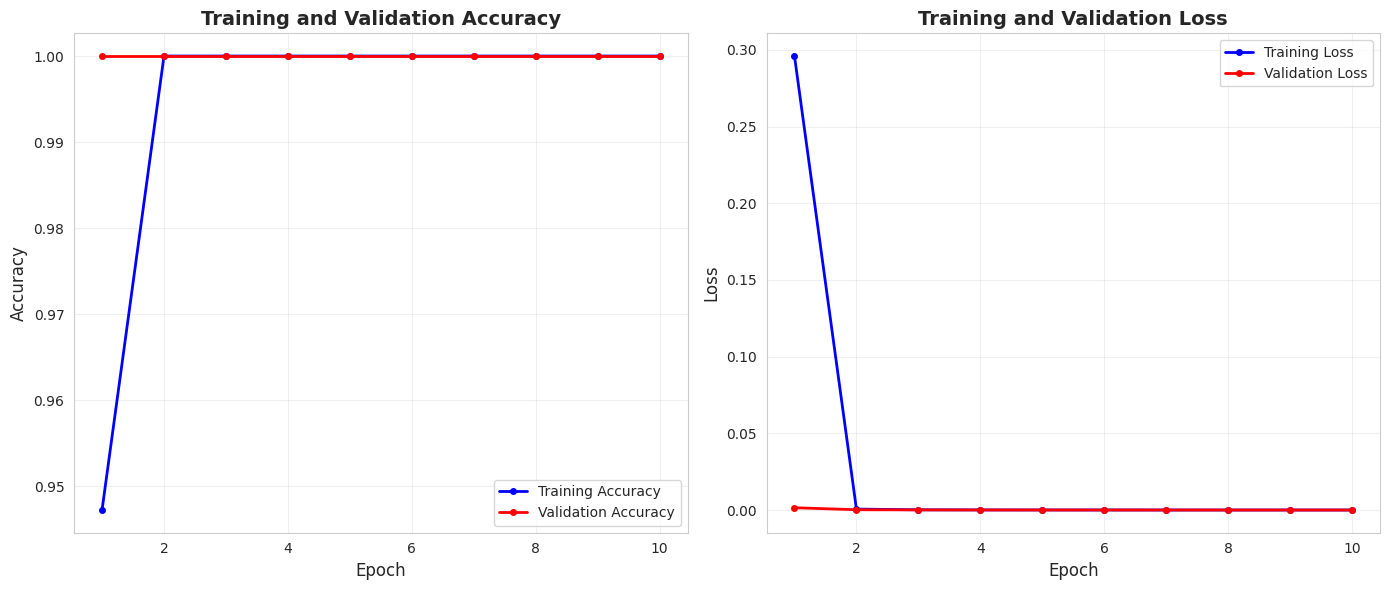


Training Summary:
Total epochs trained: 10
Best validation accuracy: 1.0000 (Epoch 1)
Final training accuracy: 1.0000
Final validation accuracy: 1.0000
Final training loss: 0.0000
Final validation loss: 0.0000



In [29]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)

# Sanskrit/Ayurvedic

In [30]:
label_map = {
    'glioma': 'mamsarbuda',
    'meningioma': 'kaphajagranthi',
    'pituitary': 'pittajagranthi',
    'no_tumor': 'swasthya'
}

In [31]:
df['label'] = df['label'].map(label_map)
balanced_train_df['label'] = balanced_train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

In [32]:
label_to_idx = {
    'mamsarbuda': 0,
    'kaphajagranthi': 1,
    'swasthya': 2,
    'pittajagranthi': 3
}
categories = list(label_to_idx.keys())

In [33]:
ft_model = fasttext.load_model("sanskrit.bin")

In [34]:
particular_label = "swasthya"
proto_emb_vec = np.expand_dims(ft_model.get_word_vector(particular_label), axis=0).astype(np.float32)

In [35]:

train_ds = make_dataset(balanced_train_df, ft_model, label_to_idx, shuffle=True)
val_ds   = make_dataset(val_df, ft_model, label_to_idx, shuffle=False)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9069 - loss: 0.5151 - val_accuracy: 1.0000 - val_loss: 5.6479e-05
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 1.0000 - loss: 1.6347e-05 - val_accuracy: 1.0000 - val_loss: 4.8610e-06
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 3.0683e-06 - val_accuracy: 1.0000 - val_loss: 1.6190e-06
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 1.6156e-06 - val_accuracy: 1.0000 - val_loss: 9.2219e-07
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 1.0000 - loss: 9.8978e-07 - val_accuracy: 1.0000 - val_loss: 6.5982e-07
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 1.0000 - loss: 8.5004e-07 - val_accuracy: 1.0000 - val_loss: 4.8804e-07
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 1.0000 - loss: 5.6570e-07 - val_accuracy: 1.0000 - val_loss: 3.9410e-07
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 5

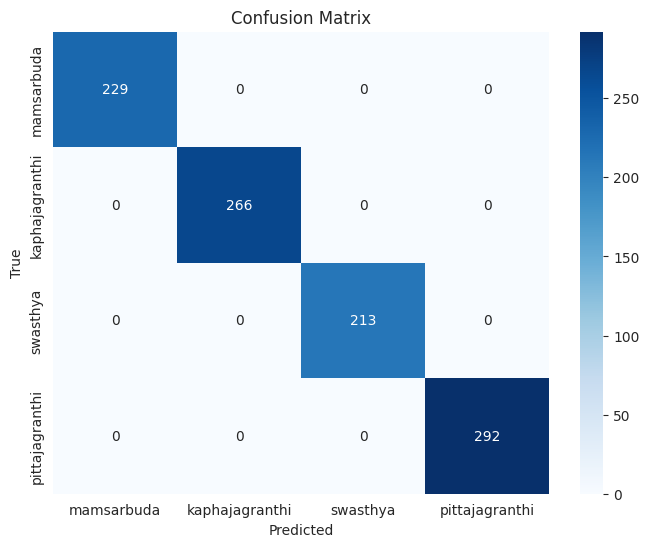

                precision    recall  f1-score   support

    mamsarbuda       1.00      1.00      1.00       229
kaphajagranthi       1.00      1.00      1.00       266
      swasthya       1.00      1.00      1.00       213
pittajagranthi       1.00      1.00      1.00       292

      accuracy                           1.00      1000
     macro avg       1.00      1.00      1.00      1000
  weighted avg       1.00      1.00      1.00      1000



In [36]:
y_true, y_pred, cm = evaluate_model(model, val_ds, categories)

# Results 

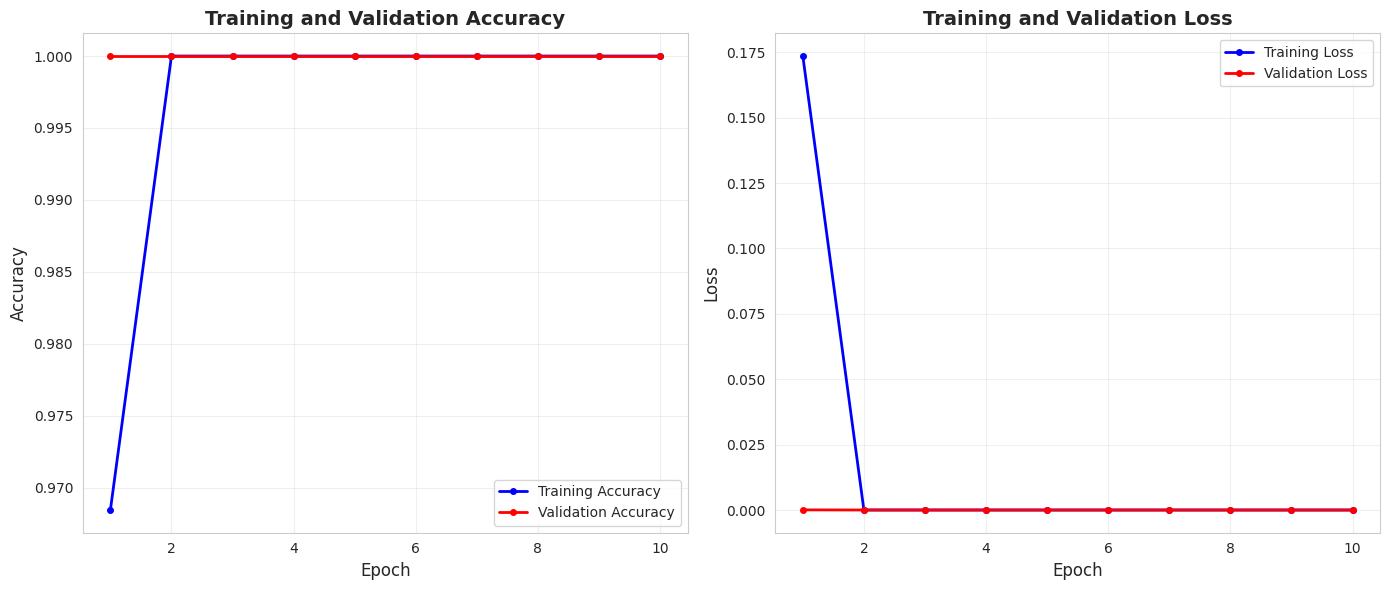


Training Summary:
Total epochs trained: 10
Best validation accuracy: 1.0000 (Epoch 1)
Final training accuracy: 1.0000
Final validation accuracy: 1.0000
Final training loss: 0.0000
Final validation loss: 0.0000



In [37]:
plot_training_history(history)

In [38]:
model.save("brain_tumor_proto_classifier_tf.keras")